In [143]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("asaniczka/pc-parts-images-dataset-classification")

print("Path to dataset files:", dataset_path)

Path to dataset files: /kaggle/input/pc-parts-images-dataset-classification


In [144]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
from torchvision.models import resnet18, ResNet18_Weights



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


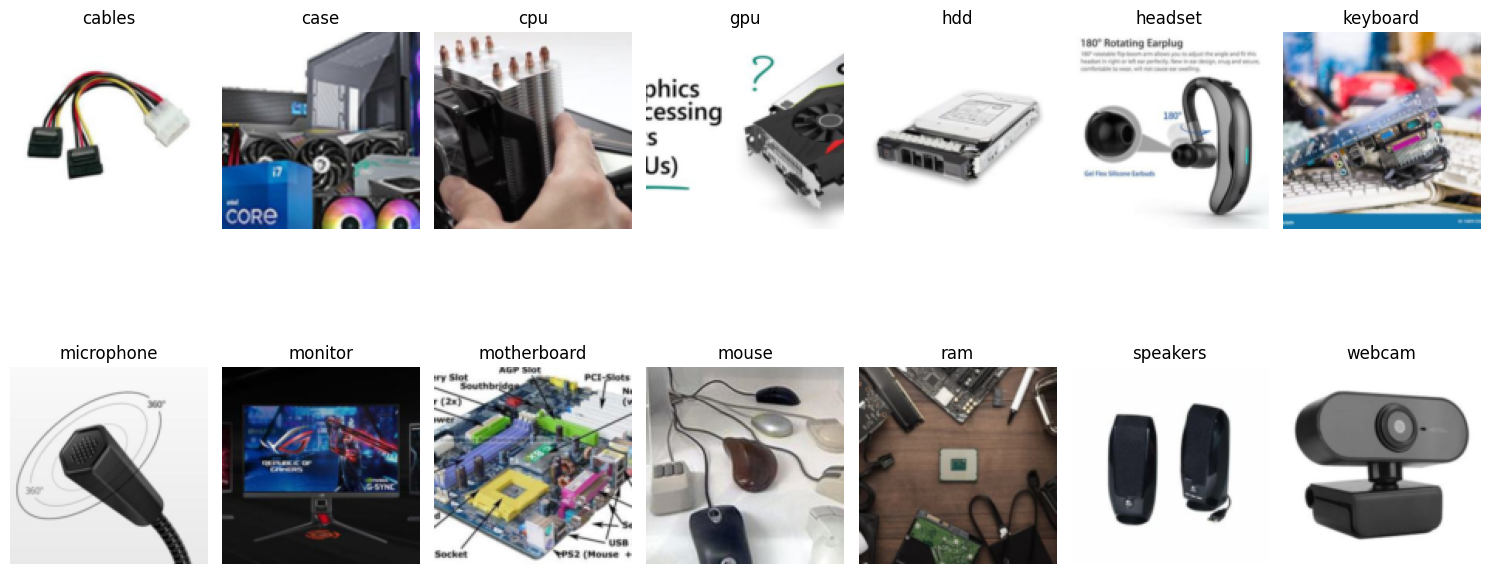

In [146]:
# Define transform for visualization (no augmentation)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# Load dataset (using the correct root path)
dataset = datasets.ImageFolder(root=dataset_path+'/pc_parts', transform=transform)
class_names = dataset.classes


# Show one image per class
shown_classes = set()
fig = plt.figure(figsize=(15, 8))

i = 1
for img_path, label in dataset.samples:
    class_name = class_names[label]
    if class_name not in shown_classes:
        shown_classes.add(class_name)

        # Load and unnormalize image for display
        img = Image.open(img_path).convert('RGB')
        raw_transform = transforms.Resize((128, 128))
        img_display = raw_transform(img) # Use a different variable name

        ax = fig.add_subplot(2, (len(class_names)+1)//2, i)
        ax.imshow(img_display) # Use the display image
        ax.set_title(class_name)
        ax.axis("off")
        i += 1

    if len(shown_classes) == len(class_names):
        break

plt.tight_layout()
plt.show()

# print All Classes ( total 14 )

In [147]:
# Print class names
print("Classes:", class_names)

Classes: ['cables', 'case', 'cpu', 'gpu', 'hdd', 'headset', 'keyboard', 'microphone', 'monitor', 'motherboard', 'mouse', 'ram', 'speakers', 'webcam']


In [148]:
def get_transform(model_type):
    if model_type.lower() == "ann":
        return transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),  # No normalization for ANN
        ])
    elif model_type.lower() == "cnn":
        return transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(0.3, 0.3, 0.3, 0.1),
            transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3),
        ])
    elif model_type.lower() == "tl":
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(0.3, 0.3, 0.3, 0.1),
            transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225]),
        ])
    else:
        raise ValueError("Invalid model_type. Choose from ['ann', 'cnn', 'tl']")


In [149]:
def load_data(model_type, dataset_path, batch_size=32, val_split=0.2):
    transform = get_transform(model_type)
    full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
    class_names = full_dataset.classes

    val_size = int(len(full_dataset)*val_split)
    train_size = len(full_dataset) - val_size
    train_set, val_set = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, class_names


In [150]:
# ANN Model
class ANNModel(nn.Module):
    def __init__(self, num_classes):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(3 * 128 * 128, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x





In [151]:
# CNN Model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [152]:

# Updated Transfer Learning Model (ResNet18)
def get_tl_model(num_classes):
    weights = ResNet18_Weights.DEFAULT
    model = resnet18(weights=weights)

    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = False

    # Replace final classification layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    # Allow training of final layer
    for param in model.fc.parameters():
        param.requires_grad = True

    return model.to(device)


In [153]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, class_names, num_epochs=10):
    best_val_acc = 0.0
    best_metrics = {'epoch': 0, 'acc': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}

    train_acc_history, val_acc_history = [], []
    train_loss_history, val_loss_history = [], []

    val_precision_history, val_recall_history, val_f1_history = [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        val_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        val_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        val_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        val_precision_history.append(val_precision)
        val_recall_history.append(val_recall)
        val_f1_history.append(val_f1)

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
              f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}, "
              f"Val Precision={val_precision:.4f}, Val Recall={val_recall:.4f}, Val F1={val_f1:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_metrics = {
                'epoch': epoch + 1,
                'acc': val_acc,
                'precision': val_precision,
                'recall': val_recall,
                'f1': val_f1
            }
            torch.save(model.state_dict(), "best_model.pth")

    print(f"\nBest Validation - Epoch: {best_metrics['epoch']} | "
          f"Acc: {best_metrics['acc']:.4f} | "
          f"Precision: {best_metrics['precision']:.4f} | "
          f"Recall: {best_metrics['recall']:.4f} | "
          f"F1: {best_metrics['f1']:.4f}")

    # Plot Loss
    epochs = range(1, num_epochs+1)
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_history, label="Train Loss")
    plt.plot(epochs, val_loss_history, label="Val Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Metrics
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc_history, label="Train Accuracy", marker='o')
    plt.plot(epochs, val_acc_history, label="Val Accuracy", marker='s')
    plt.title("Training vs Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_precision_history, label="Val Precision", marker='^')
    plt.plot(epochs, val_recall_history, label="Val Recall", marker='D')
    plt.plot(epochs, val_f1_history, label="Val F1-Score", marker='v')
    plt.title("Validation Metrics")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Load best model
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()

    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print("\n Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    plt.figure(figsize=(12, 10))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
# ✅ Return best metrics
    return {
        'Model': model.__class__.__name__,
        'Best Epoch': best_metrics['epoch'],
        'Accuracy': best_metrics['acc'],
        'Precision': best_metrics['precision'],
        'Recall': best_metrics['recall'],
        'F1-Score': best_metrics['f1']
    }

Training ANN Model...
Epoch 1/10: Train Loss=3.1456, Train Acc=0.0949, Val Loss=2.6434, Val Acc=0.0947, Val Precision=0.0446, Val Recall=0.0853, Val F1=0.0446
Epoch 2/10: Train Loss=2.6134, Train Acc=0.1166, Val Loss=2.6480, Val Acc=0.1038, Val Precision=0.1132, Val Recall=0.0953, Val F1=0.0530
Epoch 3/10: Train Loss=2.5573, Train Acc=0.1353, Val Loss=2.5647, Val Acc=0.1710, Val Precision=0.1007, Val Recall=0.1581, Val F1=0.0979
Epoch 4/10: Train Loss=2.4900, Train Acc=0.1574, Val Loss=2.5978, Val Acc=0.1206, Val Precision=0.1699, Val Recall=0.1156, Val F1=0.0941
Epoch 5/10: Train Loss=2.4268, Train Acc=0.1917, Val Loss=2.5551, Val Acc=0.1511, Val Precision=0.1487, Val Recall=0.1465, Val F1=0.1118
Epoch 6/10: Train Loss=2.3702, Train Acc=0.2146, Val Loss=2.5657, Val Acc=0.1725, Val Precision=0.1826, Val Recall=0.1727, Val F1=0.1494
Epoch 7/10: Train Loss=2.3634, Train Acc=0.2069, Val Loss=2.5479, Val Acc=0.1985, Val Precision=0.1684, Val Recall=0.1963, Val F1=0.1571
Epoch 8/10: Train L

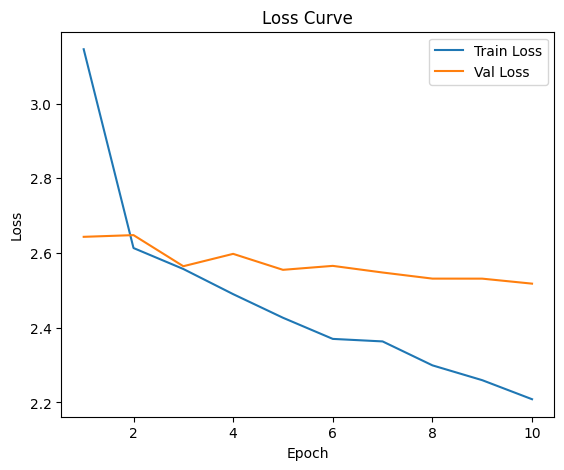

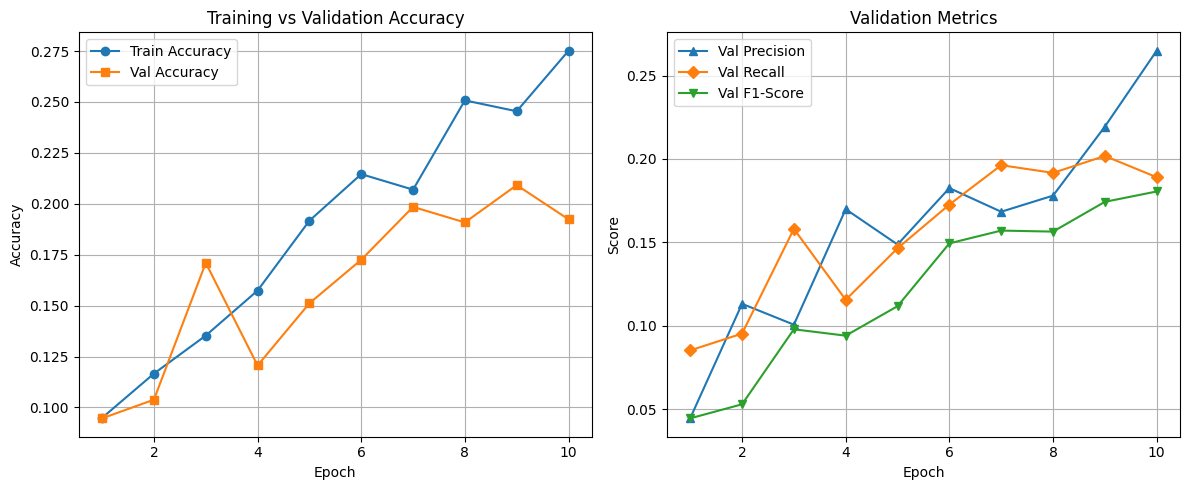


 Classification Report:
              precision    recall  f1-score   support

      cables       0.18      0.29      0.22        52
        case       0.26      0.26      0.26        53
         cpu       0.00      0.00      0.00        34
         gpu       0.00      0.00      0.00        31
         hdd       0.10      0.21      0.13        47
     headset       0.19      0.70      0.30        53
    keyboard       0.18      0.14      0.16        51
  microphone       0.17      0.05      0.08        40
     monitor       0.33      0.20      0.25        50
 motherboard       0.25      0.03      0.05        65
       mouse       0.22      0.22      0.22        50
         ram       0.50      0.04      0.08        47
    speakers       0.32      0.29      0.31        51
      webcam       0.36      0.39      0.38        31

    accuracy                           0.21       655
   macro avg       0.22      0.20      0.17       655
weighted avg       0.23      0.21      0.18       655



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1200x1000 with 0 Axes>

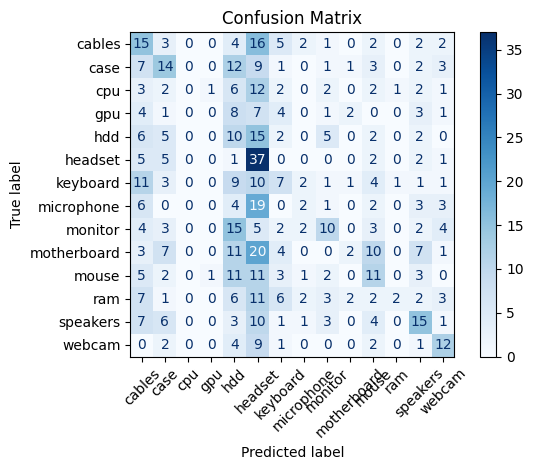

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]      25,166,336
            Linear-2                  [-1, 256]         131,328
            Linear-3                  [-1, 128]          32,896
            Linear-4                   [-1, 14]           1,806
Total params: 25,332,366
Trainable params: 25,332,366
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 0.01
Params size (MB): 96.64
Estimated Total Size (MB): 96.83
----------------------------------------------------------------


In [137]:
dataset_path = "/kaggle/input/pc-parts-images-dataset-classification/pc_parts"
num_epochs = 10
batch_size = 64

# ANN
print("Training ANN Model...")
train_loader, val_loader, class_names = load_data("ann", dataset_path, batch_size)
model = ANNModel(len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

ann_results = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, class_names)

summary(model, input_size=(3, 128 , 128))


Training CNN Model...
Epoch 1/10: Train Loss=2.6559, Train Acc=0.1071, Val Loss=2.5431, Val Acc=0.1405, Val Precision=0.0662, Val Recall=0.1149, Val F1=0.0715
Epoch 2/10: Train Loss=2.5458, Train Acc=0.1265, Val Loss=2.5214, Val Acc=0.1634, Val Precision=0.0812, Val Recall=0.1433, Val F1=0.0849
Epoch 3/10: Train Loss=2.5160, Train Acc=0.1444, Val Loss=2.4850, Val Acc=0.1511, Val Precision=0.1449, Val Recall=0.1333, Val F1=0.1080
Epoch 4/10: Train Loss=2.4531, Train Acc=0.1776, Val Loss=2.4676, Val Acc=0.1634, Val Precision=0.1953, Val Recall=0.1484, Val F1=0.1331
Epoch 5/10: Train Loss=2.4009, Train Acc=0.1966, Val Loss=2.3966, Val Acc=0.2137, Val Precision=0.1946, Val Recall=0.2013, Val F1=0.1740
Epoch 6/10: Train Loss=2.3257, Train Acc=0.2279, Val Loss=2.3448, Val Acc=0.2214, Val Precision=0.2447, Val Recall=0.1999, Val F1=0.1861
Epoch 7/10: Train Loss=2.2347, Train Acc=0.2633, Val Loss=2.2959, Val Acc=0.2504, Val Precision=0.2592, Val Recall=0.2480, Val F1=0.2279
Epoch 8/10: Train L

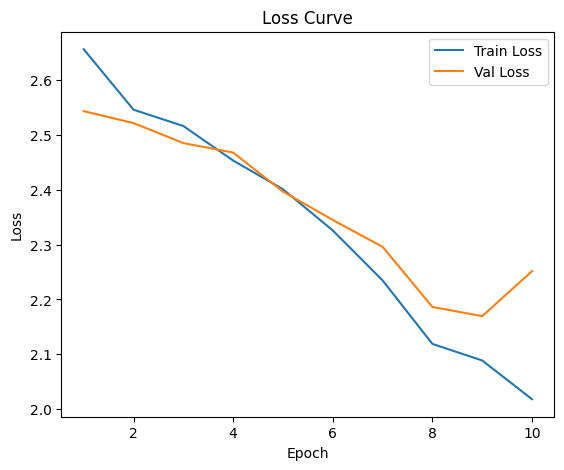

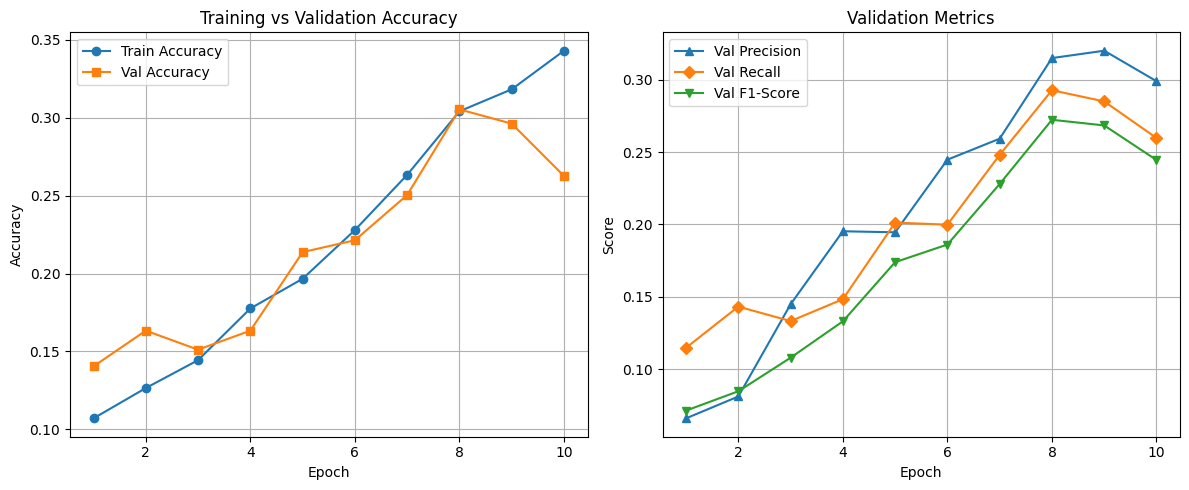


 Classification Report:
              precision    recall  f1-score   support

      cables       0.25      0.26      0.25        53
        case       0.28      0.32      0.30        65
         cpu       0.67      0.07      0.13        28
         gpu       0.10      0.03      0.04        36
         hdd       0.39      0.25      0.30        61
     headset       0.33      0.11      0.16        56
    keyboard       0.24      0.23      0.24        43
  microphone       0.43      0.14      0.21        44
     monitor       0.24      0.43      0.31        46
 motherboard       0.31      0.59      0.41        56
       mouse       0.29      0.18      0.22        39
         ram       0.50      0.15      0.23        40
    speakers       0.30      0.70      0.42        57
      webcam       0.41      0.48      0.44        31

    accuracy                           0.30       655
   macro avg       0.34      0.28      0.26       655
weighted avg       0.33      0.30      0.27       655



<Figure size 1200x1000 with 0 Axes>

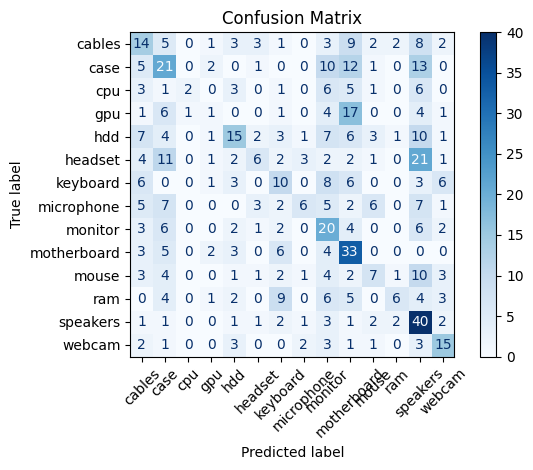

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          18,496
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
         MaxPool2d-6          [-1, 128, 16, 16]               0
            Linear-7                  [-1, 512]      16,777,728
            Linear-8                   [-1, 14]           7,182
Total params: 16,878,158
Trainable params: 16,878,158
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 8.75
Params size (MB): 64.39
Estimated Total Size (MB): 73.33
----------------------------------------------------------------


In [139]:
dataset_path = "/kaggle/input/pc-parts-images-dataset-classification/pc_parts"
num_epochs = 10
batch_size = 64
# CNN
print("Training CNN Model...")
train_loader, val_loader, class_names = load_data("cnn", dataset_path, batch_size)
model = SimpleCNN(len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
cnn_results = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, class_names)
summary(model, input_size=(3, 128, 128))


Training Transfer Learning Model (ResNet18)...
Epoch 1/10: Train Loss=2.3144, Train Acc=0.2767, Val Loss=1.8889, Val Acc=0.4595, Val Precision=0.5349, Val Recall=0.4507, Val F1=0.4272
Epoch 2/10: Train Loss=1.6551, Train Acc=0.5663, Val Loss=1.5618, Val Acc=0.5679, Val Precision=0.6139, Val Recall=0.5585, Val F1=0.5500
Epoch 3/10: Train Loss=1.3944, Train Acc=0.6181, Val Loss=1.4517, Val Acc=0.5802, Val Precision=0.6432, Val Recall=0.5646, Val F1=0.5600
Epoch 4/10: Train Loss=1.2946, Train Acc=0.6391, Val Loss=1.3258, Val Acc=0.6443, Val Precision=0.6795, Val Recall=0.6473, Val F1=0.6410
Epoch 5/10: Train Loss=1.1653, Train Acc=0.6715, Val Loss=1.2615, Val Acc=0.6580, Val Precision=0.7008, Val Recall=0.6445, Val F1=0.6492
Epoch 6/10: Train Loss=1.1080, Train Acc=0.6867, Val Loss=1.2097, Val Acc=0.6641, Val Precision=0.6726, Val Recall=0.6588, Val F1=0.6578
Epoch 7/10: Train Loss=1.0880, Train Acc=0.6886, Val Loss=1.2114, Val Acc=0.6656, Val Precision=0.7000, Val Recall=0.6589, Val F1=0

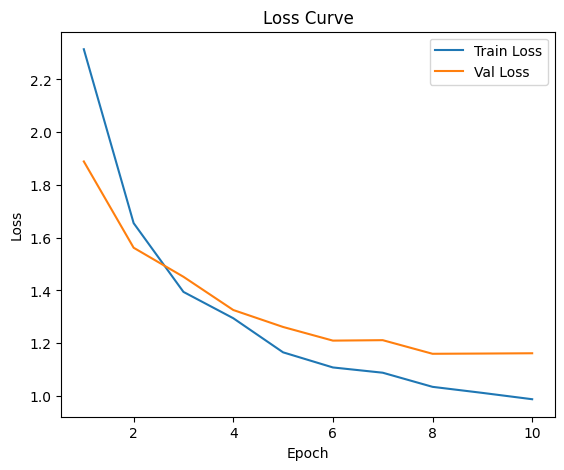

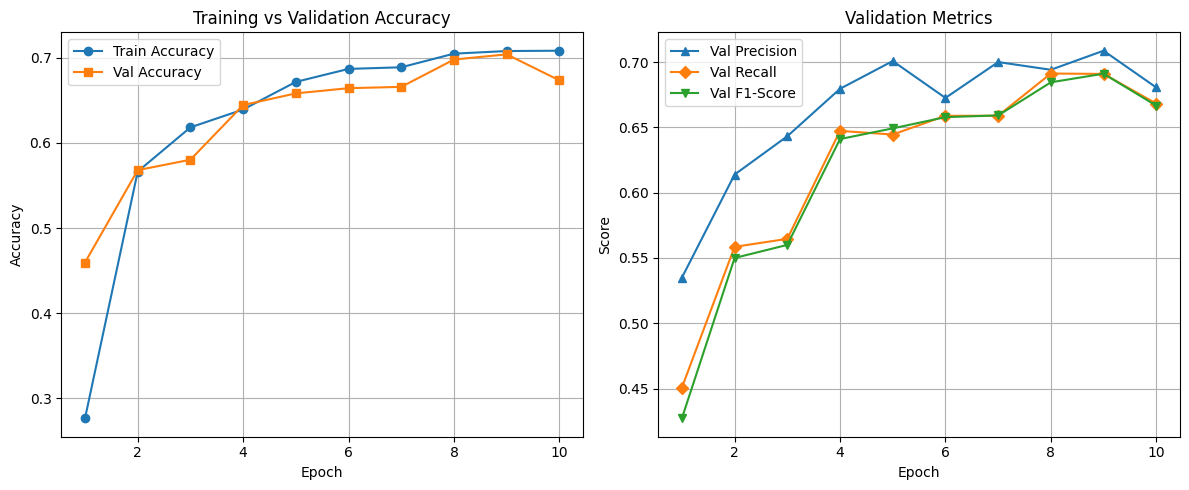


 Classification Report:
              precision    recall  f1-score   support

      cables       0.51      0.63      0.57        60
        case       0.49      0.66      0.57        68
         cpu       0.44      0.42      0.43        26
         gpu       0.56      0.42      0.48        36
         hdd       0.71      0.57      0.63        65
     headset       0.82      0.60      0.69        52
    keyboard       0.75      0.84      0.79        55
  microphone       0.69      0.76      0.72        33
     monitor       0.83      0.83      0.83        48
 motherboard       0.61      0.66      0.63        38
       mouse       0.88      0.49      0.63        43
         ram       0.69      0.78      0.73        51
    speakers       0.72      0.76      0.74        54
      webcam       0.91      0.81      0.86        26

    accuracy                           0.67       655
   macro avg       0.69      0.66      0.66       655
weighted avg       0.68      0.67      0.67       655



<Figure size 1200x1000 with 0 Axes>

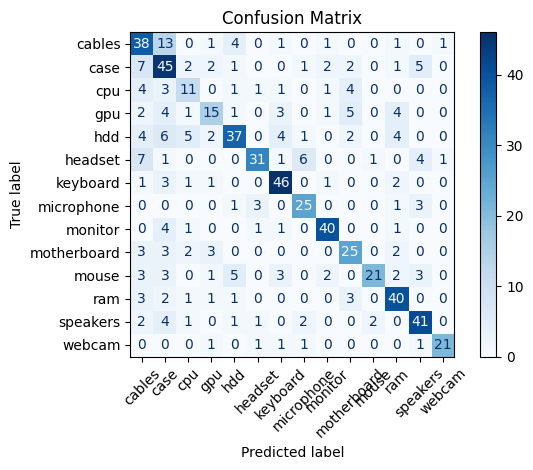

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [156]:
dataset_path = "/kaggle/input/pc-parts-images-dataset-classification/pc_parts"
num_epochs = 10
batch_size = 64
# Transfer Learning (ResNet18)
print("Training Transfer Learning Model (ResNet18)...")
train_loader, val_loader, class_names = load_data("tl", dataset_path, batch_size)
model = get_tl_model(len(class_names))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)  # only fc params
tl_results  = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, class_names)

summary(model, input_size=( 3, 224, 224))  # ResNet usually uses 224x224 input

In [157]:
model_metrics = [
    {'Model': 'ANN', **ann_results},
    {'Model': 'CNN', **cnn_results},
    {'Model': 'Transfer Learning', **tl_results}
]

df = pd.DataFrame(model_metrics)
print("\nBest Validation Metrics for Each Model:\n")
print(df.to_string(index=False))



Best Validation Metrics for Each Model:

    Model  Best Epoch  Accuracy  Precision   Recall  F1-Score
 ANNModel           9  0.209160   0.219381 0.201806  0.174316
SimpleCNN           8  0.305344   0.314868 0.292670  0.272264
   ResNet           9  0.703817   0.708709 0.690938  0.691103
